# Undiagnosed Diabetes Mellitus Prediction on general health and behavior indicators

# Setup

## Styling

In [1]:
%%html
<style>
.dashed-box {
    border: 1px dashed black !important;
#    font-size: var(--jp-content-font-size1) !important;
}

.dashed-box table {

}

.dashed-box tr {
    background-color: white !important;
}
        
.alt-tab {
    background-color: black;
    color: #ffc351;
    padding: 4px;
    font-size: 1em;
    font-weight: bold;
    font-family: monospace;
}
// add your CSS styling here
style>

## Functions

In [19]:
def display_scores(list_of_scores, models_names):
    '''A function to display evaluation metrics of trained model all in a single table facilitating their performance comparison'''
    
    results = []
    for s in list_of_scores:
            data = { 'Accuracy' : s['test_accuracy'].mean(),
                     'Precision' : s['test_precision'].mean(),
                     'Recall'    : s['test_recall'].mean(),
                     'ROC_AUC'   : s['test_roc_auc'].mean(),
                     'F1-score'  : s['test_f1'].mean()}
            results.append(data)
    
    score_table = pd.DataFrame(results, index = models_names)
    score_table.sort_values(by = 'Recall', inplace = True)
    return score_table

## Importing Libraries

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import xgboost as xgb
from IPython.display import Image
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from pandas_profiling import ProfileReport
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

sns.set_theme(style="whitegrid")

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

## Importing Dataset

In [11]:
diabetes = pd.read_csv("./diabetes/diabetes_binary_health_indicators_BRFSS2015.csv")

# Context

## Diabetes Mellitus

**Diabetes Mellitus (DM)** is a complex metabolic disease that can present different manifestations, although it is mostly characterized by *elevated levels of blood glucose*. Diabetes’ primary cause is related to Insulin deficiency (in Type I, autoimmune response that destroys insulin-producing cells) or Insulin resistance (in Type II, when insulin receptors lose their sensibility to it). <br/>
**Insulin** is an hormone that *transport glucose molecules inside cells*, where they are transformed in energy. In both DM Types cases, there is a malfunctioning of this molecular transportation mechanism [1]. As a result the *body 'starves', while blood glucose accumulate and reacts with organs and tissues* causing problems as kidney failure, blindness, heart-attack, limb amputation and strokes[1][5].

### Symptoms

Most common symptoms [2][3] are: <br/>
- excessive hunger and thirsty, <br/>
- constant urinating,<br/>
- weakness and fatigue,<br/>
- unintended weight loss,<br/>
- numb or tingling hands or feet, <br/>
- blurry vision,<br/>
- dry skin and wounds that take long to heal

### Treatments

For Type I DM patients, the only effective treatment is the *administration of insulin injections*.<br/>
Type II DM patients’ treatment is based on a *lifestyle change* that includes healthy eating and exercising. It can also be complemented with drugs that reduces the blood sugar levels (as Metformin) and Insulin injections. [1][4]


### How DM is diagnosed?

There are three tests used as standard for DM diagnosis [9] [10]:
1.	Fasting Blood sugar test, that consists in measuring blood glucose after 8-12h fasting
2.	A1C test, that consist in measuring the percentage of glycosylated hemoglobin in blood,
3.	Glucose tolerance test, that measure glycemia over time after ingestion of a controlled amount of glucose.

Depending on the combination of test results, it is possible to characterize the patient being in Normal, Prediabetes and Diabetes.


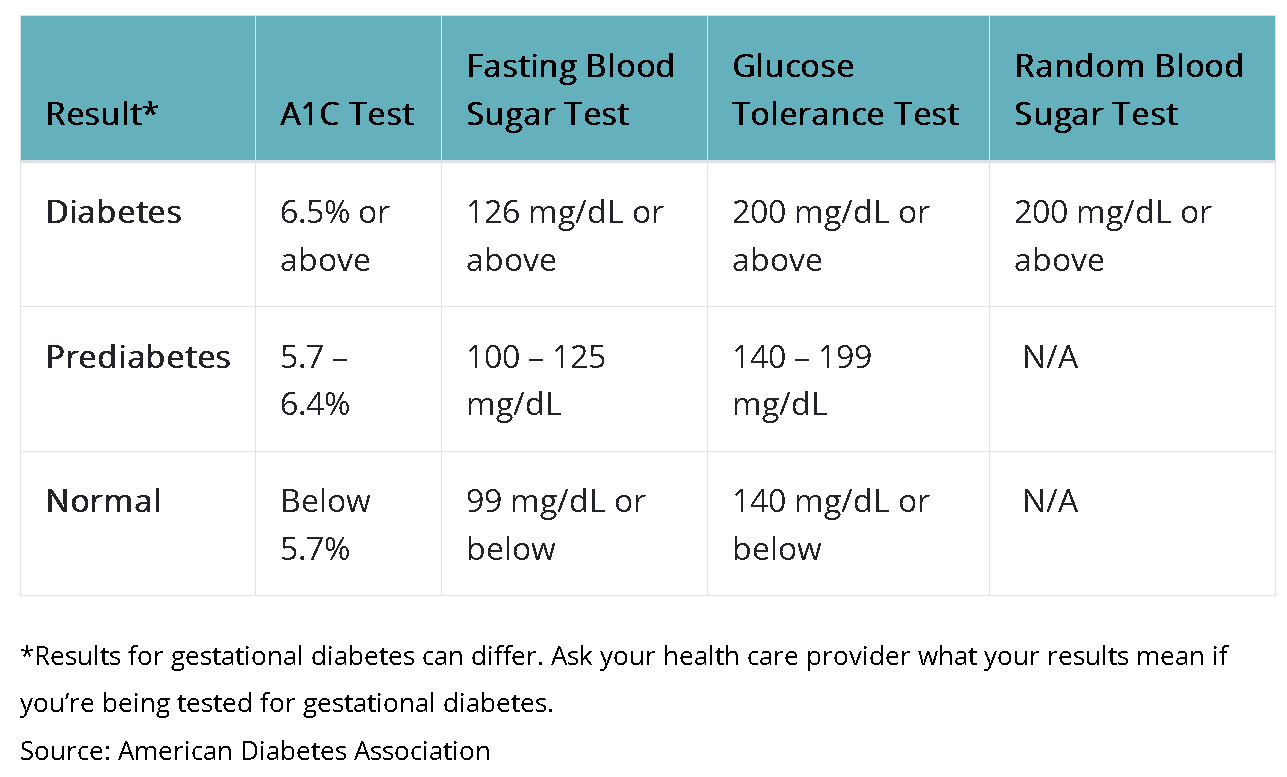

In [2]:
Image(filename='./Images/diagnosis_criteria.png', width = 600, height = 300) 

### Incidence

In 2021, **around 537 million adults live with DM worldwide**, mostly in middle and low-income countries [6]. It was 108 million cases in 1980 [5], an increase of 429 million in 41 years. Approximately 90-95% of these DM cases are classified as Type II, and in 2021 it was estimated that DM directly caused 6.7 million deaths. **In Brazil, there are 12.4 million DM cases, and 214 thousand related deaths in 2021** [6].


### Burden

DM can cause kidney failure, blindness, heart-attack, limb amputation and strokes [5]. Beyond treatment costs, there are also social and economic burdens. Worldwide, the estimated economic DM burden was of U$$ 1.3 trillion [7]. For Brazilian government, DM costed US$ 2.15 billion in 2016, considering the indirect costs of early retirement, absenteeism, and early death. The projections for 2030 are of 133% increase in cost [8].


### Motivation

DM prevalence worldwide is underestimated due to healthcare access limitations. According to Center for Disease Control (CDC), in US 1 in 5 people with DM is undiagnosed, and 8 in 10 people with prediabetes are unaware of their condition [12]. In Brazil 15.102 participants were evaluated between 2008 and 2010 at the Brazilian Longitudinal Study of Adult Health (ELSA-Brasil), where 19.7% had DM but half (50.4%) were previously undiagnosed [8]. <br/> 
Brazilians state that scheduling tests and appointments are the biggest challenges they face when using national healthcare system (40% and 38%. respectively) [14][15]. Additionally, only 15% of the system users are engaged in preventive initiatives involving physical activities.[15] <br/>

The combination of deficient health monitoring and absence of preventive DM habits in population leads to delay in diagnostic and worsen of health condition in untreated patients [15]. As a reflex, factors as related deaths, early retirement and absenteeism end up being very relevant to the DM expenditure estimation. Consequently, these indirect costs are considered to play a major contribution - around 70% - in low/medium-income countries. Including direct and indirect costs, the 2030 projection for DM related costs in Brazil surpass US$ 5 billion, more than double of the 2016 bill (133.4% increase) [8]. A 2010 study estimated that a cost for an average DM Brazilian patient was US$2108 [16]. A more recent work from 2018 considering hospitalization risk for DM patients in Brazil found that the average cost of an adult hospitalization due to diabetes was US$845, 19% higher than hospitalization without DM [17]. <br/>

Type II DM is tightly related to unhealthy eating, obesity and sedentary lifestyle, well known risk factors for developing the disease. A ML classification model for DM based on general health status and behavior of patients can greatly contribute with identifying the most at-risk individuals in our population. Its findings could benefit the public healthcare system driving to more effective targeting in actions for diagnosis expansion and preventive initiatives. An opportunity lies in the healthcare system informatization efforts, as seen in Citizen's Electronic Health Record (Prontuário Eletrônico do Cidadão - PEC) initiative. PEC consists in a software aggregating clinical and administrative patient information, and therefore could feed a DM detection model. [18]


## References


[1] Bioquímica Básica, Anita Marzocco, Bayardo Torres, 4ª edição <br/>
[2] https://www.gov.br/saude/pt-br/assuntos/saude-de-a-a-z/d/diabetes <br/>
[3] https://www.cdc.gov/diabetes/basics/symptoms.html <br/>
[4] https://www.nhs.uk/conditions/type-2-diabetes/understanding-medication/ <br/>
[5] https://www.who.int/news-room/fact-sheets/detail/diabetes <br/>
[6] https://diabetesatlas.org/ <br/>
[7] Bommer, C. et al. Global Economic Burden of Diabetes in Adults: Projections From 2015 to 2030. Diabetes Care. 2018 May;41(5):963-970. doi: 10.2337/dc17-1962. Epub 2018 Feb 23. PMID: 29475843. At https://pubmed.ncbi.nlm.nih.gov/29475843/ <br/>
[8] Pereda, P. et al. “Direct and Indirect Costs of Diabetes in Brazil in 2016”, Ann Glob Health. 2022; 88(1): 14. doi: 10.5334/aogh.3000. At https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8896241/ <br/>
[9] Cobas R, et al. Diagnóstico do diabetes e rastreamento do diabetes tipo 2. Diretriz Oficial da Sociedade Brasileira de Diabetes, 2022. doi: 10.29327/557753.2022-2, ISBN: 978-65-5941-622-6. At  https://diretriz.diabetes.org.br/diagnostico-e-rastreamento-do-diabetes-tipo-2/
[10] https://www.cdc.gov/diabetes/basics/getting-tested.html <br/>
[11] https://labiexames.com.br/ <br/>
[12] https://www.cdc.gov/diabetes/basics/quick-facts.html<br/>
[13] https://www.cdc.gov/brfss/annual_data/2015/pdf/overview_2015.pdf<br/>
[14] https://saudedasaude.anahp.com.br/fila-do-sus-marcar-exames-e-consultas-e-o-principal-desafio-dos-brasileiros/<br/>
[15] https://anahp.com.br/pdf/pesquisa-saude-que-brasileiros-querem.pdf<br/>
[16] Bahia LR, et al. The costs of type 2 diabetes mellitus outpatient care in the Brazilian public health system. Value Health. 2011 Jul-Aug;14(5 Suppl 1):S137-40. doi: 10.1016/j.jval.2011.05.009. PMID: 21839888. At https://pubmed.ncbi.nlm.nih.gov/21839888/ <br/>
[17] Rosa MQM, et al. Disease and Economic Burden of Hospitalizations Attributable to Diabetes Mellitus and Its Complications: A Nationwide Study in Brazil. Int J Environ Res Public Health. 2018 Feb 8;15(2):294. doi: 10.3390/ijerph15020294. PMID: 29419786; PMCID: PMC5858363. At https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5858363/ <br/>
[18] https://aps.saude.gov.br/noticia/2300 <br/>
[19] https://sisaps.saude.gov.br/esus/ <br/>
[20] https://g1.globo.com/saude/noticia/2021/11/14/dia-mundial-do-diabetes-157-milhoes-de-brasileiros-vivem-com-a-doenca-diz-relatorio.ghtml <br/>
<br/>
---

# Baseline

Build a Machine Learning solution to automatically predict patients with undiagnosed Diabetes Mellitus from general health and behavior indicators.

### Solution Planning:
- *Classification problem*
- Metrics:
    - Recall
- Data sources:
    - [2015 Behavioral Risk Factor Surveillance System Survei in Diabetes](https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset?select=diabetes_binary_health_indicators_BRFSS2015.csv)
- No assumptions

### Project deliverable:
- A ML system/model

---

# Data description

## About the Data 
Our dataset is derived from the 2015  Land-Line and Cell-Phone survey carried annually to investigate Diabetes risk factors, promoted by the Behavioral Risk Factor Surveillance System (BRFSS). As a collaborative project managed by CDC, their goal is to  collect uniform, state-specific data on preventive health practices and risk behaviors that are linked to chronic diseases, injuries, and preventable infectious diseases that affect the adult population.[13] <br/>

More specifically the data here analyzed consists in a pre-processed dataset derived from the original and available at Kagle, containing 21 features, a binary target variable, and not balanced. This dataset can be fount here:
    https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset?select=diabetes_binary_health_indicators_BRFSS2015.csv
<br/>

The original dataset containing all the features can be found here:
    https://www.kaggle.com/code/alexteboul/diabetes-health-indicators-dataset-notebook/data?select=2015.csv
<br/>
The codebook for all the features can be found here:
    https://www.cdc.gov/brfss/annual_data/2015/pdf/codebook15_llcp.pdf
<br/>    
The features adopted in our analysis are also described below, in 'Data Catalog'

## Data Catalog

- ``Diabetes_binary`` - Our target. 0 = no diabetes; 1 = diabetes
- ``HigBP`` - High Blood Presure. 0 = no HighBP; 1 = HighBP
- ``HighChol`` - High Cholesterol. 0 = no HighChol; 1 = HighChol
- ``CholCheck`` - Cholesterol Check in the last 5 years. 0 = no cholesterol check; 1 = yes cholesterol check
- ``BMI`` - Body Mass Index. [More info](https://en.wikipedia.org/wiki/Body_mass_index)
- ``Smoker`` - Indicates if the person have smoked at least 100 cigarrets in your entire life. 0 = no; 1 = yes
- ``Stroke`` - Have ever had a stroke. 0 = no; 1 = yes
- ``HeartDiseaseorAttack`` - Have ever had a heart disease or attack. Coronary hear disease or myocardial infraction. 0 = no; 1 = yes
- ``PhysActivity`` - Have praticed physical activity in past 30 days (not including job). 0 = no; 1 = yes
- ``Fruits`` - Have consumed fruit 1 or more times per day. 0 = no; 1 = yes
- ``Veggies`` - Have consumed vegetables 1 or more times per day. 0 = no; 1 = yes
- ``HvyAlcoholConsump`` - If men having more than 14 drinks per week or if women having more than 7 drinks per week. 0 = no; 1 = yes
- ``AnyHealthcare`` - Have any kind of health care coverage. 0 = no; 1 = yes
- ``NoDocbcCost`` - Was there a time on the past 12 years when you nedded to see a doctor but could not because of cost. 0 = no; 1 = yes
- ``GenHlth`` - Would you say that in general your health in a scale between 0 to 5 is. 1 = excellent; 2 = very good; 3 = good; 4 = fair; 5 = poor; 7 = don’t know/not Sure; 9 = refused.
- ``MentHlth`` - Now thinking about your mental health, which includes stress, depression, and problems with emotions, for how many days during the past 30 days was your mental health not good? 1 - 30 = number of days
- ``PhysHlth`` - Now thinking about your physical health, which includes physical illness and injury, for how many days during the past 30 days was your physical. 1 - 30 = number of days
- ``DiffWalk`` - Do you have serious difficulty walking or climbing stairs? 0 = no; 1 = yes
- ``Sex`` - 0 = female; 1 = male
- ``Age`` - 1 = 18-24; 2 = 25-29; 3 = 30-34; 4 = 35-39; 5 = 40-44; 6 = 45-49; 7 = 50-54; 8 = 55-59; 9 = 60-64; 10 = 65-69; 11 = 70-74; 12 = 75-79; 13 = 80 or older
- ``Education`` - 1 = Never attended school; 2 = Elementary school; 3 = High school incomplete; 4 = High school graduate; 5 = Some college or technical school; 6 = College graduate; 9 = refused to answer
- ``Income`` - Is your annual household income from all sources.<br/>
1 = Less than $10,000;  2 = Less than $15,000 ($10,000 to less than $15,000);<br/>
3 = Less than $20,000 ($15,000 to less than $20,000);  4 = Less than $25,000 ($20,000 to less than $25,000)<br/>
5 = Less than $35,000 ($25,000 to less than $35,000);  6 = Less than $50,000 ($35,000 to less than $50,000)<br/>
7 = Less than $75,000 ($50,000 to less than $75,000);  8 = $75,000 or more <br/>


*As seen in 'Data Catalog', the dataset information could be splited into 3 groups:*

* Health status: Tell us about the presence of others know illnesses
* Behavior: Inform about respondent recent behaviors
* Socio-economic: Track the respondent profile
<br/>

---

# Exploratory Data Analysis

## Data Profiling

In [12]:
#generating a data profile report with Pandas Profiling
diabetes.profile_report()

In [18]:
#Investigating features pointed as highly correlated by Pandas Profiling
diabetes[['GenHlth', 'PhysHlth', 'DiffWalk']].corr()

GenHlth  PhysHlth  DiffWalk
GenHlth   1.000000  0.524364  0.456920
PhysHlth  0.524364  1.000000  0.478417
DiffWalk  0.456920  0.478417  1.000000

#### Data Profiling Outputs
- 11369 duplicate rows were found at the dataset. This sums 4.5% of the total entries.
- During data aquisition the method assumes that duplicity at instances can occur - as the same person could be contacted by Land-Line and Cell-Phone and respond twice. However, duplicity is also possible when two different people have the same answer set, and due to confidentiality issues there is no identificator to differentiate them. As it is not possible to identify the source of a duplicated entry, method-derived duplicates can not be removed in case they are present. Anyway, we consider these cases a rare event once the survey comprises a very long query, and we assume that people already reached would not respond again. 
- General Health, Physical Health and Difficulty to walk are considered highly correlated features by Pandas Profiling. Although this features correlations show the highest values between all the assessed, their r-values are at most 0.52, wich is not considered very high.
- Since there are not very highly correlated features in our dataset, it was not necessary to exclude anything to train our model.
- Automated tools are very handy in bringing a wider view in a short time and code expense - but must be used critically! For instance, if not further investigated our obtained results in Pandas Profiling report could be misleading.
---


# Data Pre-processing

## Data Specifications

The data used in this project was previously sanitized. We proceed then investigating data types and presence of null values on our dataset. Next, we analyzed the data distribution and data correlation between variables - using Pandas Profile module.

In [5]:
#checking for data type and null entries
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_binary       253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

## Data Balancing 

After exploratory analysis we spoted a high degree of unbalance in the target variable ("Diabetes_binary"), with only **13%** of the samples being of positive class. Therefore, it will be necessary to create a balanced dataset before training our models. 

In [3]:
#Examining the distribution between classes in target variable
diabetes['Diabetes_binary'].value_counts(normalize = True)

0.0    0.860667
1.0    0.139333
Name: Diabetes_binary, dtype: float64

In [4]:
#Balancing data

#Create a mask to split our dataset in negative and positive cases
mask = diabetes['Diabetes_binary'] == 1


diabetes_pos = diabetes[mask]
diabetes_neg = diabetes[~mask]

#Using positive class mask-filtered data to create a downsapled negative class dataset
diabetes_downsampled = resample(diabetes_neg, 
                                replace = False, 
                                n_samples = len(diabetes_pos), 
                                random_state = 13)

#Concatenating the same length positive and negative class dataset to obtain a target-balanced dataset
diabetes_balanced = pd.concat([diabetes_pos, 
                               diabetes_downsampled])

#Checking if the balancing worked as expected (0.5 for each class)
diabetes_balanced['Diabetes_binary'].value_counts(normalize = True)

1.0    0.5
0.0    0.5
Name: Diabetes_binary, dtype: float64

In [5]:
#Saving the balanced dataset
diabetes_balanced.to_csv('./diabetes/diabetes_balanced.csv', index = False)

In [6]:
#Spliting data into train and test set
diabetes_train, diabetes_test = train_test_split(diabetes_balanced, test_size=0.2, random_state=13, stratify = diabetes_balanced['Diabetes_binary'])

In [7]:
#This one we continue to use
diabetes_train.to_csv('./diabetes/diabetes_train.csv', index = False)
#This we keep for our final validation
diabetes_test.to_csv('./diabetes/diabetes_test.csv', index = False)

#### Data Pre-processing Outputs
- No cleaning steps were necessary, once our dataset was already sanitized from origin.
- This reflects on complete absence of non-null entries verified;
- All features are from 'float64' type, but only 'BMI', 'MentHlth' and 'PhysHlth' are numeric. Other features are categorical, with (mostly) binary or multiclass entries.
- A Downsampling approach was considered for balancing our dataset, that has more than 250k instances. The balanced dataset would still be of a sufficient size for training, and this seemed a better alternative than generating synthetic data for Upsampling.
---


# Preparing for training

## Setup the train dataset

To enable proper model evaluation, the whole dataset is divided into train and test datasets - the first to train designated models and perform cross-validation technique, and the last, that remained unseen throughout all this analysis, to actually provide a evaluation metric for model performance assessment in novel data.  

In [8]:
#Importing the previously prepared train dataset csv file in a variable
diabetes_train = pd.read_csv('./diabetes/diabetes_train.csv')

In [9]:
#Defining the target variable (target)
y_train = diabetes_train['Diabetes_binary']

In [10]:
#Defining the feature variables 
diabetes_train = diabetes_train.drop(columns =['Diabetes_binary'])

In [11]:
#Checking shape and matching length
print(f"Shape X: {diabetes_train.shape} & Shape y: {y_train.shape}")

Shape X: (56553, 21) & Shape y: (56553,)


## Spliting features by data type

To start our training journey we need to separate our data according to its types. To do this, lists were created for each data type containing the respective columns and then transformations were applied to them with the use of scikit-learn Pipelines.

In [25]:
#Setting up each variables group 

#Categorical variables
cat_vars = ['GenHlth', 'Age', 'Education', 'Income']

#Numerical variables
num_vars = ['MentHlth', 'PhysHlth', 'BMI']

#Binary Variables
bin_vars = ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex' ]

## Creating tranforming pipelines

As said, we are using Pipelines to tranform the data. Althougth our data is already sanitazed we must establish rules for future data inputs. Also, categorical features with more than one class will be transformed with one-hot encoding to ensure that all classes within a feature has the same weight.

In [ ]:
#Pipeline applied to Numerical Features
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('robust_scaler', RobustScaler())
])

#Pipeline applied to Binary Features
bin_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))  
])

#Pipeline applied to Categorical Features
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('one-hot-encoding', OneHotEncoder(handle_unknown='ignore'))
])

# (name, transformer, columns)
preprocessed_pipeline = ColumnTransformer([
    ('numerical', num_pipeline, num_vars),
    ('binary', bin_pipeline, bin_vars),
    ('categorical', cat_pipeline, cat_vars)
])

In [16]:
#Running the features train dataset through standard pipeline
X_train = preprocessed_pipeline.fit_transform(diabetes_train)

In [17]:
X_train.shape

(56553, 110)

In [18]:
y_train.shape

(56553,)

#### Preparing for training outputs

- Our training dataset ended up containing 56553 instances.
- The Pipeline transform included scaling and imputing strategies and encoding strategies. 
For scaling, the RobustScaler method was choose for being the least influence by outliers from the available methods. <br/>
For inputing, a SimpleImputer method with most frequent strategy was chosen, in order to follow the data tendency. <br/>
For encoding, OneHotEncoder was used, to assure that different classes in a feature has the same weight during training. This is the reason for the increase in feature number - from 21 to 101 features. 

---


# Training and Model Validation

## Training Raw Models
In this phase our goal was to test a range of viable classification models, using cross validation techniques, and measure their performance according to a evaluation metrics set comprising recall, precision, accuracy, etc. 

Based on best recall metrics, three of these models was be selected to optimization with fine-tunning. 

### KNN

In [26]:
knn = KNeighborsClassifier()

knn_score = cross_validate(knn, 
                           X_train,
                           y_train,
                           cv=10,
                           scoring=('accuracy', 'precision', 'recall', 'roc_auc', 'f1'), 
                           return_train_score=False,
                           n_jobs = -1)

pickle.dump(knn_score, open('knn_score.pkl', 'wb'))

### Logistic Regression

In [27]:
log_reg = LogisticRegression()

log_reg_score = cross_validate(log_reg,
                               X_train,
                               y_train,
                               cv=10,
                               scoring=('accuracy', 'precision', 'recall', 'roc_auc', 'f1'),
                               return_train_score=False,
                               n_jobs = -1)

pickle.dump(log_reg_score, open('log_reg_score.pkl', 'wb'))

### Naive Bayes

In [28]:
naive_bayes = BernoulliNB()

naive_bayes_score = cross_validate(naive_bayes, 
                                   X_train,
                                   y_train, 
                                   cv=10, 
                                   scoring=('accuracy', 'precision', 'recall', 'roc_auc', 'f1'), 
                                   return_train_score=False, 
                                   n_jobs = -1)

pickle.dump(naive_bayes_score, open('naive_bayes_score.pkl', 'wb'))

### Linear SVM

In [29]:
svm = LinearSVC()

svm_score = cross_validate(svm,
                           X_train, 
                           y_train, 
                           cv=10, 
                           scoring=('accuracy', 'precision', 'recall', 'roc_auc', 'f1'),
                           return_train_score=False, 
                           n_jobs = -1)

pickle.dump(svm_score, open('svm_score.pkl', 'wb'))

### Stochastic Gradient Descent SVM (SGDClassifier)

In [30]:
svm_sgd = SGDClassifier()

svm_sgd_score = cross_validate(svm,
                               X_train, 
                               y_train, 
                               cv=10, 
                               scoring=('accuracy', 'precision', 'recall', 'roc_auc', 'f1'), 
                               return_train_score=False, 
                               n_jobs = -1)

pickle.dump(svm_sgd_score, open('svm_sgd_score.pkl', 'wb'))

### SVM kernel

In [31]:
svm_poly = SVC(kernel='poly')

svm_poly_score = cross_validate(svm_poly, 
                                X_train, 
                                y_train, 
                                cv=10, 
                                scoring=('accuracy', 'precision', 'recall', 'roc_auc', 'f1'), 
                                return_train_score=False, 
                                n_jobs=-1, 
                                verbose=True)

pickle.dump(svm_poly_score, open('svm_poly_score.pkl', 'wb'))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 32.9min finished


In [32]:
svm_rbf = SVC(kernel='rbf')

svm_rbf_score = cross_validate(svm_rbf, 
                               X_train,
                               y_train, 
                               cv=10, 
                               scoring=('accuracy', 'precision', 'recall', 'roc_auc', 'f1'), 
                               return_train_score=False, 
                               n_jobs=-1, 
                               verbose= True)

pickle.dump(svm_rbf_score, open('svm_rbf_score.pkl', 'wb'))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 27.4min finished


### Decision Tree

In [33]:
tree = DecisionTreeClassifier()

tree_score = cross_validate(tree, 
                            X_train, 
                            y_train, 
                            cv=10, 
                            scoring=('accuracy', 'precision', 'recall', 'roc_auc', 'f1'), 
                            return_train_score=False, 
                            n_jobs = -1)

pickle.dump(tree_score, open('tree_score.pkl', 'wb'))

### Random Forest

In [34]:
forest = RandomForestClassifier()

forest_score = cross_validate(forest, 
                              X_train, 
                              y_train, 
                              cv=10, 
                              scoring=('accuracy', 'precision', 'recall', 'roc_auc', 'f1'), 
                              return_train_score=False, 
                              n_jobs = -1)

pickle.dump(forest_score, open('forest_score.pkl', 'wb'))

## Evaluating Raw Models

Here we employ the function defined previously to display all the calculated evaluation metrics at once, to make it easier selecting which models would follow to optimization.

In [35]:
#Creating a list of model's score after cross validation
list_of_scores = [knn_score, log_reg_score, naive_bayes_score, svm_score, svm_sgd_score, svm_poly_score, svm_rbf_score, tree_score, forest_score]
models_names = ['KNN', 'LogReg', 'NBayes', 'Linear SVM', "SGD-SVM", "SVM-Poly", "SVM-RBF", "Decision Tree", "Random Forest"]

In [36]:
#Calling the function for evaluation metrics display defined previously 
display_scores(list_of_scores, models_names)

Accuracy  Precision    Recall   ROC_AUC  F1-score
Decision Tree  0.656216   0.657385  0.652545  0.655761  0.654933
NBayes         0.725108   0.729390  0.715812  0.801881  0.722517
KNN            0.699892   0.691777  0.721081  0.756600  0.706112
Random Forest  0.734249   0.716798  0.774552  0.805578  0.744536
LogReg         0.747122   0.733891  0.775507  0.823751  0.754108
SVM-Poly       0.745725   0.727624  0.785621  0.818581  0.755494
Linear SVM     0.746645   0.726544  0.791173  0.822864  0.757456
SGD-SVM        0.746662   0.726462  0.791492  0.822860  0.757545
SVM-RBF        0.746786   0.718335  0.812109  0.822513  0.762327

#### Training and Model Validation Outputs
It was observed in evaluation metrics for raw models that:
- It is relevant to remind the reader that the models assessed were tested with default features.
- Models' accuracy values do not differ significantly from respective F1-score values, because a balanced training dataset was used.
- The poorest performance was observed for the Decision Tree, probably due to the lack of hyperparameters adjustment. Althought, finding an ideal Decision Tree is a very complex computational problem, and often lead to overfitting.
- KNN method also did not performed better than others. However, Considering the high dimensionality of our training set (101 features) it was not surprising, given the difficulty in importance estimattion when there are many simultaneous distance metrics - the dimensionality curse.
- SVM models performances were very similar between them, with RBF kernel showing the best Recall value. It also scored the lowest Precision, but it does not seem to affect the predictive power of the model, since the ROC curve score is virtually the same as the others (and better than seen in Poly kernel). 

Our main goal was to identify the larger number of positives cases of diabetes in our population, considering the nature of our problem. We aimed to avoid the Type II error (false negative). Therefore, we established highest **Recall** values as model selection criteria to next stage of fine tunning and model improvement. 

To add diversity to the results, we avoided the selection of models that uses the same implementation technique, as seen in SVM variations explored. For that reason the **SVM with RBF kernel, Logistic Regression and Random Forest models** were selected for optimization.

---

# Evaluation of Ensemble methods
Ensemble methods combines estimators, features and sampling strategies in order to obtain increased model performances. <br/>
Here we made the same rational as for the fine-tunning selection, choosing the best Recall scoring models to compose the ensemble estimators: **SVM with RBF kernel, Logistic Regression and Random Forest models**. <br/>
Unfornutally we bumped into computer power limitations, so from now on samples (n = 1000) of our data were used to test and run known optimization techniques. 

## Creating samples

In [64]:
#Importing the training dataset
diabetes_sample = pd.read_csv('./diabetes/diabetes_train.csv')

In [65]:
#Creating the sample
diabetes_sample = diabetes_sample.sample(n=1000, random_state=13)

In [66]:
#Defining the target variable (target)
y_sample = diabetes_sample['Diabetes_binary']

In [67]:
#Defining the features variables
X_sample = diabetes_sample.drop(columns =['Diabetes_binary'])

In [68]:
#Checking for the sample shape
print(f"Shape X: {X_sample.shape} & Shape y: {y_sample.shape}")

Shape X: (1000, 21) & Shape y: (1000,)


In [69]:
#Running the sample dataset through standard pipeline
X_sample = preprocessed_pipeline.fit_transform(X_sample)

In [70]:
X_sample.shape

(1000, 93)

## Voting Classifier

In [43]:
#Hard Voting
lr_clf = LogisticRegression()
svm_rbf = SVC(kernel='rbf')
rnd_forest = RandomForestClassifier()


estimators = [('lr', lr_clf), ('svm_rbf', svm_rbf), ('rnd_forest', rnd_forest)]

voting = VotingClassifier(estimators, voting='hard', n_jobs=-1)
voting.fit(X_train, y_train)
voting_score = cross_validate(voting, X_sample, y_sample, cv=10, scoring='recall')

pickle.dump(voting_score, open('voting_score.pkl', 'wb'))

In [44]:
#Retrieving Hard Voting Recall
voting_score['test_score'].mean()

0.778265602322206

## Bagging 

### Bagging + SVM With RBF Kernel

In [46]:
# Using rbf kernel SVM as estimator
bagging = BaggingClassifier(svm_rbf, 
                            n_jobs=-1, 
                            random_state=13)

bagging.fit(X_train, y_train)

bagging_svm_score = cross_validate(bagging, 
                                   X_sample,
                                   y_sample,
                                   cv=50, 
                                   scoring= 'recall', 
                                   return_train_score=False, 
                                   n_jobs = -1)

pickle.dump(bagging_svm_score, open('bagging_svm_score.pkl', 'wb'))

The svm_rbf result after bagging: 0.7539999999999998


In [ ]:
#Retrieving Bagging + SVM_RBF Recall
print(f"The svm_rbf Recall: {svm_rbf_score['test_recall'].mean()}")
print(f"The svm_rbf Recall after bagging: {bagging_svm_score['test_score'].mean()}")

### Bagging + Logistic Regression

In [48]:
# Using logistic regression as estimator

bagging = BaggingClassifier(lr_clf, 
                            n_jobs=-1, 
                            random_state=13)

bagging.fit(X_train, y_train)

bagging_lr_score = cross_validate(bagging, 
                                   X_sample,
                                   y_sample, cv=33, 
                                   scoring= 'recall', 
                                   return_train_score=False, 
                                   n_jobs = -1)

pickle.dump(bagging_lr_score, open('bagging_lr_score.pkl', 'wb'))

The LogReg result: 0.7386363636363636
The LogReg result after bagging: 0.7386363636363636


In [ ]:
#Retrieving Bagging + Log Reg Recall
print(f"The LogReg Recall: {log_reg_score['test_recall'].mean()}")
print(f"The LogReg Recall after bagging: {bagging_lr_score['test_score'].mean()}")

### Bagging + Random Forest

In [51]:
# Using random forest as estimator

bagging = BaggingClassifier(rnd_forest, 
                            n_jobs=-1, 
                            random_state=13)

bagging.fit(X_train, y_train)

bagging_rdn_forest_score = cross_validate(bagging, 
                                   X_sample,
                                   y_sample, cv=33, 
                                   scoring= 'recall', 
                                   return_train_score=False, 
                                   n_jobs = -1)

pickle.dump(bagging_rdn_forest_score, open('bagging_rdn_forest_score.pkl', 'wb'))

print(f"The random forest Recall: {forest_score['test_recall'].mean()}")
print(f"The random forest Recall after bagging: {bagging_rdn_forest_score['test_score'].mean()}")

The random forest result: 0.774552319045134
The random forest result after bagging: 0.7919191919191919


In [ ]:
#Retrieving Bagging + Random Forest Recall
print(f"The random forest Recall: {forest_score['test_recall'].mean()}")
print(f"The random forest Recall after bagging: {bagging_rdn_forest_score['test_score'].mean()}")

## Boosting

### XGBoost

In [52]:
#XGBoost Training w/ all the training set
xgboost = xgb.XGBClassifier()
xgboost_score = cross_validate(xgboost, X_train, y_train, cv=10, scoring= 'recall' , return_train_score=False, n_jobs = -1)
pickle.dump(xgboost_score, open('xgboost_score.pkl', 'wb'))

In [53]:
#Retrieving XGBoost Forest Recall
xgboost_score['test_score'].mean()

0.7898296458328435

#### Evaluation of Ensemble methods Outputs

For the Voting Classifier, we ran the Hard voting method. A Soft Voting approach would be intersting, but can not be executed with estimators that do not predict probability for classes (*predict_proba*), which is the case of SVM with RBF kernel. Recall for Voting Classifiers with our selected estimators was not better than the simple Recall mean of the three weak estimators alone. <br/>

Different from Voting Classifier, Bagging employs repetitions of a single type of estimator running in parallel, with a bootstrapping strategy for increasing samples variance. We then tested three versions of Bagging methods, each with one of the selected models (SVM with RBF kernel, Logistic Regression, Random Forest). Only *Random Forest Bagging* returned a higher recall value (0.7919) than Random Forest alone (0.7745). Considering the natural tendency to overfitting of Random Forest, the Bagging strategy may have incresed the model variance, promoting a better generalization.  <br/>

Boosting approach applies training with weak learners sequencially, where the next predictor is configured to decrease the previous learner error. Analysing Reccal metrics for our training set, the XGBoost was not better than our best isolated model, SVM with RBF kernel (values of 0.7898 and 0.8121 respectively)<br/>

When considered the high computational processing cost of ensemble methods, the shy increase of recall metrics observed in Bagging+Random Forest (0.0174) may not be a good trade-off.

---

# Hyperparamenter Tuning 

We choose the best three models of each type according to the Recall measurements for optimization: 

- Logistic Regression
- SVM-RBF
- Random Forest

Optimizing algorithms has a high computational cost. To circunvent this, we employed the sample also used for Ensemble methods, as discussed before.

## GridSearch

### SVM with RBF Kernel

In [56]:
# SVM-RBF
model = svm_rbf
C = np.arange(0.1, 100, 1)
gamma = [0.1, 1, 10, 100]

parameters = dict(C = C,
                  gamma = gamma
                 )

# define grid search

cv = RepeatedStratifiedKFold(n_splits=5, 
                             n_repeats=3, 
                             random_state=13)

grid_search = GridSearchCV(estimator=model, 
                           param_grid=parameters, 
                           n_jobs=-1, 
                           cv=cv, 
                           scoring='recall',
                           error_score=0)

grid_result_svm = grid_search.fit(X_sample, y_sample)

pickle.dump(grid_result_svm, open('grid_result_svm.pkl', 'wb'))

Best result: 1.0 & best parameter: {'C': 0.1, 'gamma': 1}


In [ ]:
#Retrieving SVM_RBF Recall
print(f"Best Recall: {grid_result.best_score_} & best parameter: {grid_result.best_params_}")

### Logistic Regression

In [54]:
# Logistic Regression
model = lr_clf
C = np.logspace(0, 1, 50)
penalty = ['l1', 'l2']
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

parameters = dict(C = C,
                  penalty = penalty,
                  solver = solver)

# define grid search

cv = RepeatedStratifiedKFold(n_splits=5, 
                             n_repeats=3, 
                             random_state=13)

grid_search = GridSearchCV(estimator=model, 
                           param_grid=parameters, 
                           n_jobs=-1, 
                           cv=cv, 
                           scoring='recall',
                           error_score=0)

grid_result_lr = grid_search.fit(X_sample, y_sample)

pickle.dump(grid_result_lr, open('grid_result_lr.pkl', 'wb'))

Best result: 0.7406288156288156 & best parameter: {'C': 1.93069772888325, 'penalty': 'l1', 'solver': 'saga'}


C:\Users\conra\anaconda3\envs\ML_IFSP\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
2250 fits failed out of a total of 7500.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
750 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\conra\anaconda3\envs\ML_IFSP\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\conra\anaconda3\envs\ML_IFSP\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\conra\anaconda3\envs\ML_IFSP\lib\site-packages\sklearn\linear_model\_logistic.py"

In [ ]:
#Retrieving Logistic Regression Recall
print(f"Best Recall: {grid_result_lr.best_score_} & best parameter: {grid_result_lr.best_params_}")

### Random Forest

In [55]:
# Random Forest
model = rnd_forest
n_estimators = np.arange(50, 250, 10)
criterion = ["gini", "entropy", "log_loss"]
bootstrap = [True, False]

parameters = dict(n_estimators = n_estimators,
                  criterion = criterion,
                  bootstrap = bootstrap)

# define grid search

cv = RepeatedStratifiedKFold(n_splits=5, 
                             n_repeats=3, 
                             random_state=13)

grid_search = GridSearchCV(estimator=model, 
                           param_grid=parameters, 
                           n_jobs=-1, 
                           cv=cv, 
                           scoring='recall',
                           error_score=0)

grid_result_rdn_forest = grid_search.fit(X_sample, y_sample)

pickle.dump(grid_result_rdn_forest, open('grid_result_rdn_forest.pkl', 'wb'))

Best result: 0.7871123321123321 & best parameter: {'bootstrap': True, 'criterion': 'gini', 'n_estimators': 130}


In [ ]:
#Retrieving Random Forest Recall
print(f"Best result: {grid_result_rdn_forest.best_score_} & best parameter: {grid_result_rdn_forest.best_params_}")

#### Hyperparamenter Tuning Outputs

No increase in recall metrics were observed when running Grid Search for Logistic Regression and Random Forest models. In the other hand, recall of SVM with RBF kernel reached a value of 1, which means that all positive cases are correctly identified with the hyperparameters suggested. Which seems suspect. An entire dataset labeled as positive also record a recall equals 1. We proceeded with the hyperparameters pointed for SVM_RBF, but being aware of any inconsistency. <br/>

There are two possible limitations for the optimizations here performed. First of all, sample size may had influenced results, once bigger sample could have offered higher data variability to be explored. Second, GridSearch algorithm has limited space to perform its search. This offers a gain in processing, but if the selected features or the search interval for them are not relevant, it may not return a real optimization. For a complete and random search, one could be using the RandonSearch algorithm. We declined this option due to processing limitations.<br/>

Whitin all the considerations, the *best model identified by our work is the* ***SVM with RBF kernel, with hyperparameters C = 0.1 and gamma = 1 .***

---

# Model Validation in Test Set (Unseen data)

With trained models and best hyperparameters values defined, it is times to test them against the test set. 

## Preparing the Test Set

In [ ]:
#pickle.dump(model, open('model.pkl', 'wb'))
svm_rbf_score = pickle.load(open('./pickle/svm_rbf_score.pkl', 'rb'))

In [158]:
#Loading test dataset 
diabetes_test = pd.read_csv('./diabetes/diabetes_test.csv')

In [159]:
#Defining the target variable (target)
y_test = np.array(diabetes_test['Diabetes_binary'])

In [129]:
#Defining the features variables
X_test = diabetes_test.drop(columns = ['Diabetes_binary'], axis = 1)

In [132]:
X_test = preprocessed_pipeline.fit_transform(X_test)

## Testing models

### SVM

In [93]:
#Training SVM_RBF
svm_rbf = SVC(kernel='rbf', C = 0.1)
svm_rbf.fit(X_train, y_train)

SVC(C=0.1)

In [166]:
#Predicting classification with SVM_RBF
svm_pred = svm_rbf.predict(X_val)

In [167]:
#Computating evaluation metrics
recall_svm = recall_score(y_test, svm_pred)
accuracy_svm = accuracy_score(y_test, svm_pred)
precision_svm = precision_score(y_test, svm_pred)
roc_auc_svm = roc_auc_score(y_test, svm_pred)
f1_svm = f1_score(y_test, svm_pred)

Recall score: 0.8013863347008063
Accuracy score: 0.7483556121366434
Precision score: 0.7245172016881954
ROC_AUC score: 0.7483593625413508
F1 score: 0.7610155830198819


### Random Forest

In [143]:
#Training Random Forest
rdn_forest = RandomForestClassifier(bootstrap = True, criterion = 'gini', n_estimators = 130)
rdn_forest.fit(X_train, y_train)
pickle.dump(rdn_forest, open('rdn_forest.pkl', 'wb'))

In [ ]:
#Predicting classification with Random Forest
forest_pred = rdn_forest.predict(X_test)

In [164]:
#Computating evaluation metrics
recall_forest = recall_score(y_test, forest_pred)
accuracy_forest = accuracy_score(y_test, forest_pred)
precision_forest = precision_score(y_test, forest_pred)
roc_auc_forest = roc_auc_score(y_test, forest_pred)
f1_forest = f1_score(y_test, forest_pred)

Recall score: 0.7824303296081483
Accuracy score: 0.7361906782657897
Precision score: 0.7161724718373689
ROC_AUC score: 0.7361939483967191
F1 score: 0.747836668469443


### Logistic Regression

In [144]:
#Training Logistic Regression
log_reg = LogisticRegression(C = 1.93069772888325, penalty = 'l1', solver = 'saga')
log_reg.fit(X_train, y_train)

C:\Users\conra\anaconda3\envs\ML_IFSP\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [169]:
#Predicting classification with Logistic Regression
log_reg_pred = log_reg.predict(X_test)

In [170]:
#Computating evaluation metrics
recall_log_reg = recall_score(y_test, log_reg_pred)
accuracy_log_reg = accuracy_score(y_test, log_reg_pred)
precision_log_reg = precision_score(y_test, log_reg_pred)
roc_auc_log_reg = roc_auc_score(y_test, log_reg_pred)
f1_log_reg = f1_score(y_test, log_reg_pred)

Recall score: 0.7786108360447023
Accuracy score: 0.748001980338072
Precision score: 0.7336710210610504
ROC_AUC score: 0.7480041450379099
F1 score: 0.7554732001921625


## Exhibiting Models' evaluation metrics

Visualizing the comparative results from the best 3 models selected at training stage.

In [179]:
#Imputing data 
data = {'Logistic Regression': [recall_log_reg, accuracy_log_reg, precision_log_reg, roc_auc_log_reg, f1_log_reg],
        'Random Forest': [recall_forest, accuracy_forest, precision_forest, roc_auc_forest, f1_forest],
        'SVM-RBF': [recall_svm, accuracy_svm, precision_svm, roc_auc_svm, f1_svm]}

In [183]:
#Creating a dataframe
test_results = pd.DataFrame(data, index = ['Recall', 'Accuracy', 'Precision', 'ROC_AUC', 'F1']).T.sort_values(by = "Recall", ascending = False)

In [184]:
#Showcasing in tabular form
test_results

Recall  Accuracy  Precision   ROC_AUC        F1
SVM-RBF              0.801386  0.748356   0.724517  0.748359  0.761016
Random Forest        0.782430  0.736191   0.716172  0.736194  0.747837
Logistic Regression  0.778611  0.748002   0.733671  0.748004  0.755473

#### Model Validation in Test Set (Unseen data) Outputs

All models apllied showed good results. This metrics, derived from test set, are not far from the ones spotted in training set. The models are doing a decent job in generalizating the classification. 
<br/>

Our elected model is ***SVM with RBF kernel, with hyperparameters C = 0.1 and gamma = 1*** as already seen in training validation, with best Recall (0.8013), ROC_AUC, Accuracy and F1-Score metrics.

---

# Discussion and future steps

As limitations of this work, we encoutered computational processing barrier. This conditioned us to make use of sample data to run algorithms as Ensemble methods and GridSearch fine tunning, which possibly influenced our optimization results. In retrospect, the use of manual optimization could be employed to enrich our results in training stage. <br/>

Whithin our study, the proposed model is capable of correctly classify 80% of patients with DM that run by it. As discussed, DM has a serious diagnostic gap in Brazil - around 50% of total people with the disease are undiagnosed [20]- with critical impact in public health system, economy and society. Considering that patients screened are potentially unaware of its illness, this findings could lead to proper diagnostic and treatment for these people, and consequently improved quality of life and extended lifespan.  <br/>
In a broader view, this application would reduce the diagnostic gap, revealing a more realistic disease prevalence. This can better orient the provision of resources for prevention actions and treatment for DM, estimated in US$2000 per patient/year. <br/>

For future work, we plan:
- Establish thresholds for the discovery of pre-diabetic patients based on probabilities. 
- Develop the least viable model based on the most relevant features, making data acquisition feasible and less expensive.
- Develop data ingestion with DATASUS for automatically input new local data. 
- Develop a unsupervised machine learning model to reduce annotated data dependency.

---